# Shapely

In [54]:
from shapely.geometry import Polygon

# create a room
room = Polygon([(0, 0), (4, 0), (4, 3), (0, 3)])

# check if a new room intersects with the existing room
new_room = Polygon([(3, 2), (6, 2), (6, 5), (3, 5)])
print(new_room)
print(room.intersects(new_room))  # True


POLYGON ((3 2, 6 2, 6 5, 3 5, 3 2))
True


In [55]:
# check its type
print(type(room.exterior.coords))
print(type(room.exterior.coords[0]))

<class 'shapely.coords.CoordinateSequence'>
<class 'tuple'>


## Point
useful, but not flexible enough

In [56]:
from shapely.geometry import Point

vertex = Point(10.1, 20.1)
print(vertex)

room = Polygon([Point(10, 20), Point(15, 20), Point(15, 25), Point(10, 25)])
print(room)
print(vertex.within(room))  # True

vertex = Point(vertex.x + 2, vertex.y + 3)
print(vertex)

POINT (10.1 20.1)
POLYGON ((10 20, 15 20, 15 25, 10 25, 10 20))
True
POINT (12.1 23.1)


# Matplotlib

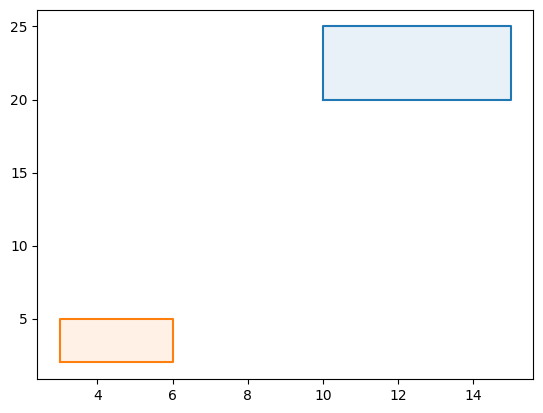

In [57]:
rooms = [room, new_room]
def draw_polygons(rooms):
    import matplotlib.pyplot as plt
    for room in rooms:
        x, y = room.exterior.xy
        plt.fill(x, y, alpha=0.1)
        plt.plot(x, y)
    plt.show()

draw_polygons(rooms)


# NetworkX

In [58]:
import networkx as nx

# define the connection of the rooms
floor_plan = nx.Graph()
floor_plan.add_edges_from([
    ("Living Room", "Kitchen"),
    ("Living Room", "Bedroom"),
    ("Bedroom", "Bathroom"),
    ("Laundry", "Hallway"),
])

print(nx.is_connected(floor_plan))  # check if the graph one single connected component

False


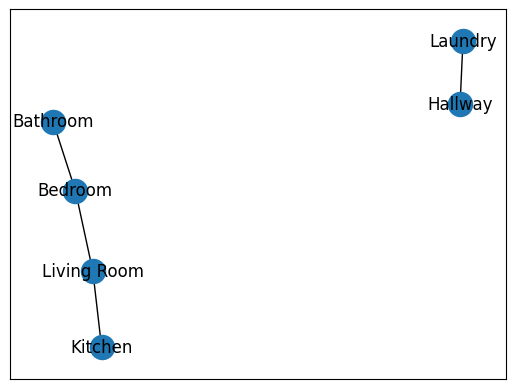

In [59]:
# print floor_plan
import matplotlib.pyplot as plt
pos = nx.spring_layout(floor_plan)
nx.draw_networkx_nodes(floor_plan, pos)
nx.draw_networkx_edges(floor_plan, pos)
nx.draw_networkx_labels(floor_plan, pos)
plt.show()

# Pygame  
**Later**, develop an interactive interface

In [60]:
# import pygame

# pygame.init()
# screen = pygame.display.set_mode((500, 500))

# # create a room
# room = pygame.Rect(50, 50, 100, 150)

# running = True
# while running:
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             running = False

#     screen.fill((255, 255, 255))
#     pygame.draw.rect(screen, (200, 100, 100), room)
#     pygame.display.flip()

# pygame.quit()


# Generate

In [61]:
from shapely.geometry import Polygon

class Room:
    def __init__(self, room_type, x, y, width, height):
        self.room_type = room_type
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.polygon = Polygon([(x, y), (x, y + height), (x + width, y + height), (x + width, y)])

    def __str__(self):
        return f"Room {self.room_type}: {self.polygon.exterior.coords[:]}"

    def __repr__(self):
        return str(self)

# some constraints
## house constraints

In [62]:
min_house_width = 10
max_house_width = 20
min_house_depth = 15
max_house_depth = 40

## room constraints

In [124]:
min_room_width = 1
max_room_width = 6
min_room_depth = 2
max_room_depth = 8

In [125]:
# Generate a room
def generate_room(type, x, y, width, height):
    return Room(type, x, y, width, height)

# Seems useless, might as will create a new room
def adjust_room_position(room, direction):
    # direction_x, direction_y
    d_x, d_y = direction
    # change all x, y coordinates of the room's polygon
    room.polygon = Polygon([(x + d_x, y + d_y) for x, y in room.polygon.exterior.coords])

In [126]:
# test adjust_room_position function
room = generate_room('living_room', 0, 0, 4, 4)
print(room)
adjust_room_position(room, (1, 1))
print(room)

Room living_room: [(0.0, 0.0), (0.0, 4.0), (4.0, 4.0), (4.0, 0.0), (0.0, 0.0)]
Room living_room: [(1.0, 1.0), (1.0, 5.0), (5.0, 5.0), (5.0, 1.0), (1.0, 1.0)]


In [127]:
# check candidate room's overlap with existing rooms
def check_overlap(new_room, existing_rooms):
    for room in existing_rooms:
        # because intersect: overlap + touch + within
        if new_room.polygon.intersects(room.polygon) and not new_room.polygon.touches(room.polygon):
            if room.room_type == 'Living Room':
                room.polygon = room.polygon.difference(new_room.polygon)
                continue
            else:
                return True
    return False

import networkx as nx

# check candidate room's connection with existing rooms
# only one cluster is allowed
def check_single_cluster(new_room, existing_rooms):
    # check if the new room is connected and one cluster
    adjacent_graph = nx.Graph()
    adjacent_graph.add_node(new_room)
    cropped_lv_room = None

    for room in existing_rooms:
        adjacent_graph.add_node(room)
        # if the new room touches the existing room
        if new_room.polygon.touches(room.polygon):
            adjacent_graph.add_edge(new_room, room)
        # if the new room overlaps the existing room
        elif new_room.polygon.intersects(room.polygon):
            if room.room_type == 'Living Room':
                # print('cutting living room')
                cropped_lv_room = room.polygon.difference(new_room.polygon)
                # continue
            else:
                return False
    # if the new room overlaps with the living room
    # the living room should be replaced by the cropped room 
    if nx.is_connected(adjacent_graph):
        if cropped_lv_room is not None:
            for room in existing_rooms:
                if room.room_type == 'Living Room':
                    print('replacing living room')
                    room.polygon = cropped_lv_room
        return True
    else:
        return False

In [128]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

def draw_polygon(polygon):
    # if multi-polygon, draw all polygons
    if polygon.geom_type == 'MultiPolygon':
        for sub_polygon in polygon.geoms:
            x, y = sub_polygon.exterior.xy
            plt.fill(x, y, alpha=0.1)
            plt.plot(x, y)
    else:
        x, y = polygon.exterior.xy
        plt.fill(x, y, alpha=0.1)
        plt.plot(x, y)
    
def draw_rooms(rooms):
    print('Number of rooms:', len(rooms))
    for room in rooms:
        draw_polygon(room.polygon)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.show()

Dining Room placed!
Number of rooms: 2


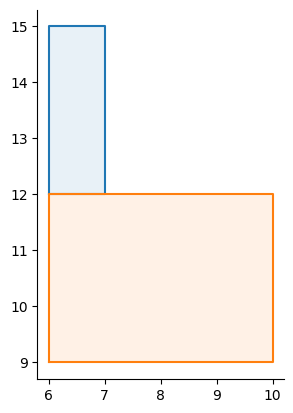

Master Bedroom placed!
Number of rooms: 3


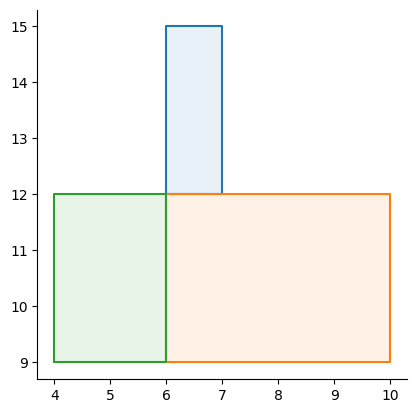

Kitchen placed!
Number of rooms: 4


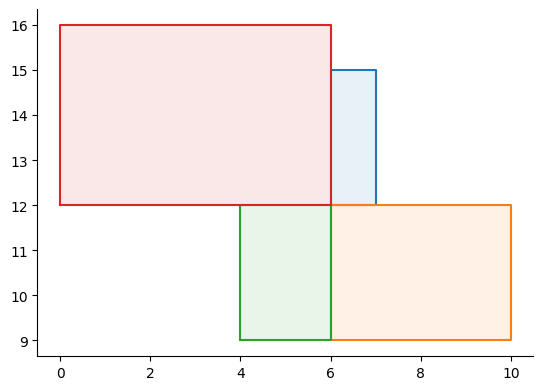

In [ ]:
import random

# Generate a random reasonable house plan
def generate_random_house():
    placed_rooms = []
    # first room is the living room
    x, y = random.randint(0, 15), random.randint(0, 15)
    width_LR = random.randint(1, 6)
    depth_LR = random.randint(2, 8)
    placed_rooms.append(generate_room("Living Room", x, y, width_LR, depth_LR))

    room_types = ["Dining Room", "Master Bedroom", "Kitchen", "Bedroom", "Bathroom", "Hallway", "Balcony"]
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]  # Right, Up, Left, Down
    for room_type in room_types:
        while True:
            width, height = random.randint(min_room_width, max_room_width), random.randint(min_room_depth, max_room_depth)
            x, y = random.randint(0, 15), random.randint(0, 15)
            new_room = generate_room(room_type, x, y, width, height)
            if check_single_cluster(new_room, placed_rooms):
                break

        placed_rooms.append(new_room)
        print(f'{new_room.room_type} placed!')
        draw_rooms(placed_rooms)
            
    return placed_rooms

random_house = generate_random_house()